In [1]:
!pip install transformer
!pip install gdown

import os
import sys

if not os.path.exists('/kaggle/working/efficient-kan'):
    !git clone https://github.com/Blealtan/efficient-kan

if '/kaggle/working/efficient-kan/src' not in sys.path:
    sys.path.append('/kaggle/working/efficient-kan/src')

ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer
Cloning into 'efficient-kan'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 90 (delta 22), reused 14 (delta 14), pack-reused 61 (from 1)
Unpacking objects: 100% (90/90), 33.24 KiB | 1.11 MiB/s, done.


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Repair dataset

In [3]:
!gdown --id 1jz-AF1nxIVv7jvzxOm8HlOgHQF1ZO9nC

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jz-AF1nxIVv7jvzxOm8HlOgHQF1ZO9nC
To: /kaggle/working/combined_data.csv
100%|██████████████████████████████████████| 76.4M/76.4M [00:00<00:00, 93.4MB/s]


In [4]:
raw_data = pd.read_csv('/kaggle/working/combined_data.csv')
raw_data.head()

,url,title,description,content,cat,subcat,content_length
0,https://vnexpress.net/ly-do-seo-ton-tai-vinh-v...,Lý do sẹo tồn tại vĩnh viễn,Mô sẹo có cấu tạo khác biệt so với da thông th...,[Caption: Vùng da bị sẹo có nhiều khác biệt vớ...,khoa học,thường thức,2919
1,https://vnexpress.net/nha-may-di-dong-san-xuat...,Nhà máy di động sản xuất gạch không vữa từ đốn...,Nhà máy có thể sản xuất 8.000 viên gạch giống ...,[Caption: Nhà máy sản xuất gạch di động khá nh...,khoa học,tin tức,2489
2,https://vnexpress.net/lo-phan-ung-hut-nuoc-bie...,Lò phản ứng hút nước biển để sản xuất hydro tr...,MỸCác nhà khoa học tại Viện Công nghệ Massachu...,Hai nhà nghiên cứu MIT Aly Kombargi (trái) và ...,khoa học,tin tức,2633
3,https://vnexpress.net/cac-san-pham-ai-noi-bat-...,Các sản phẩm AI nổi bật của VinBigdata,Đội ngũ phát triển của VinBigdata tạo dấu ấn v...,"Trợ lý ảo ViVi 2.0\n""ViVi 2.0 tích hợp công ng...",khoa học,khoa học trong nước,4807
4,https://vnexpress.net/tia-gamma-manh-nhat-tron...,Tia gamma mạnh nhất trong vũ trụ,Nhóm nghiên cứu đến từ Trung Quốc phát hiện dò...,[Caption: Mô phỏng chớp tia gamma sáng nhất GR...,khoa học,tin tức,1882


In [5]:
def preprocess_1(text):
    text = text.replace('[Caption: ', '')
    text = text.replace(']', '')
    return text

# def preprocess_2(text):
#     while text.find('(') != -1:
#         st = text.find('(')
#         en = text.find(')')
#         text = text[:st] + text[en:]
#     return text

raw_data['content'] = raw_data['content'].apply(preprocess_1)
# raw_data['content'] = raw_data['content'].apply(preprocess_2)
raw_data['content_length'] = raw_data['content'].apply(len)
raw_data.head()

,url,title,description,content,cat,subcat,content_length
0,https://vnexpress.net/ly-do-seo-ton-tai-vinh-v...,Lý do sẹo tồn tại vĩnh viễn,Mô sẹo có cấu tạo khác biệt so với da thông th...,Vùng da bị sẹo có nhiều khác biệt với da xung ...,khoa học,thường thức,2908
1,https://vnexpress.net/nha-may-di-dong-san-xuat...,Nhà máy di động sản xuất gạch không vữa từ đốn...,Nhà máy có thể sản xuất 8.000 viên gạch giống ...,"Nhà máy sản xuất gạch di động khá nhỏ gọn, đặt...",khoa học,tin tức,2467
2,https://vnexpress.net/lo-phan-ung-hut-nuoc-bie...,Lò phản ứng hút nước biển để sản xuất hydro tr...,MỸCác nhà khoa học tại Viện Công nghệ Massachu...,Hai nhà nghiên cứu MIT Aly Kombargi (trái) và ...,khoa học,tin tức,2633
3,https://vnexpress.net/cac-san-pham-ai-noi-bat-...,Các sản phẩm AI nổi bật của VinBigdata,Đội ngũ phát triển của VinBigdata tạo dấu ấn v...,"Trợ lý ảo ViVi 2.0\n""ViVi 2.0 tích hợp công ng...",khoa học,khoa học trong nước,4785
4,https://vnexpress.net/tia-gamma-manh-nhat-tron...,Tia gamma mạnh nhất trong vũ trụ,Nhóm nghiên cứu đến từ Trung Quốc phát hiện dò...,Mô phỏng chớp tia gamma sáng nhất GRB 221009A ...,khoa học,tin tức,1871


In [6]:
print(raw_data['cat'].unique())
print('Maximum content length:', raw_data['content_length'].max())
print('Num samples:', raw_data.shape[0])

['khoa học' 'giải trí' 'bất động sản' 'kinh doanh' 'số hóa' 'thể thao'
 'pháp luật' 'giáo dục' 'du lịch' 'sức khỏe' 'các bệnh' 'đời sống' 'xe'
 'xã hội' 'thế giới' 'an sinh' 'văn hóa' 'lao động - việc làm' 'thời sự'
 'bảo vệ người tiêu dùng' 'công nghiệp hỗ trợ' 'tuần việt nam' 'chính trị'
 'thông tin và truyền thông' 'bạn đọc' 'nội dung chuyên đề'
 'dân tộc - tôn giáo' 'nông thôn mới' 'dân tộc thiểu số và miền núi'
 'tình yêu - giới tính']
Maximum content length: 47702
Num samples: 17044


* 'khoa học' => 'khcn'
* 'bất động sản' => 'kinh tế'
* 'kinh doanh' => 'kinh tế'
* 'số hóa' => 'khcn'
* 'các bệnh' => 'sức khỏe'
* 'đời sống' => 'xã hội'
* 'xe' => remove
* 'an sinh' => 'xã hội'
* 'lao động - việc làm' => 'kinh tế'
* 'thời sự' => 'xã hội'
* 'bảo vệ người tiêu dùng' => 'kinh tế'
* 'công nghiệp hỗ trợ' => 'khcn'
* 'tuần việt nam' => 'xã hội'
* 'thông tin và truyền thông' => remove
* 'bạn đọc' => remove
* 'nội dung chuyên đề' => remove
* 'dân tộc - tôn giáo' => 'xã hội'
* 'nông thôn mới' => 'xã hội'
* 'dân tộc thiểu số và miền núi' => 'văn hóa'
* 'tình yêu - giới tính' => 'văn hóa'

In [7]:
# Dictionary for replacing values
replace_dict = {
    'khoa học': 'khcn',
    'công nghiệp hỗ trợ': 'khcn',
    'bảo vệ người tiêu dùng': 'kinh tế',
    'bất động sản': 'kinh tế',
    'kinh doanh': 'kinh tế',
    'số hóa': 'khcn',
    'các bệnh': 'sức khỏe',
    'đời sống': 'xã hội',
    'an sinh': 'xã hội',
    'lao động - việc làm': 'kinh tế',
    'thời sự': 'xã hội',
    'tuần việt nam': 'văn hóa',
    'dân tộc - tôn giáo': 'xã hội',
    'nông thôn mới': 'xã hội',
    'dân tộc thiểu số và miền núi': 'văn hóa',
    'tình yêu - giới tính': 'văn hóa'
}

# Replace values
raw_data['cat'].replace(replace_dict, inplace=True)

# Drop rows with specified values
raw_data = raw_data[~raw_data['cat'].isin([
    'xe', 
    'thông tin và truyền thông', 
    'bạn đọc', 
    'nội dung chuyên đề',
])]

/tmp/ipykernel_17/2311177570.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  raw_data['cat'].replace(replace_dict, inplace=True)


In [8]:
print(raw_data['cat'].unique())

['khcn' 'giải trí' 'kinh tế' 'thể thao' 'pháp luật' 'giáo dục' 'du lịch'
 'sức khỏe' 'xã hội' 'thế giới' 'văn hóa' 'chính trị']


In [9]:
category_to_number = {
    "chính trị": 1,
    "xã hội": 2,
    "kinh tế": 3,
    "văn hóa": 4,
    "sức khỏe": 5,
    "pháp luật": 6,
    "thế giới": 7,
    "khcn": 8,
    "thể thao": 9,
    "giải trí": 10,
    "du lịch": 11,
    "giáo dục": 12
}

In [10]:
raw_data['encoded_cat'] = raw_data['cat'].map(category_to_number)
print(raw_data['encoded_cat'].unique())
num_classes = len(raw_data['encoded_cat'].unique())
print('Number of classes:', num_classes)

[ 8 10  3  9  6 12 11  5  2  7  4  1]
Number of classes: 12


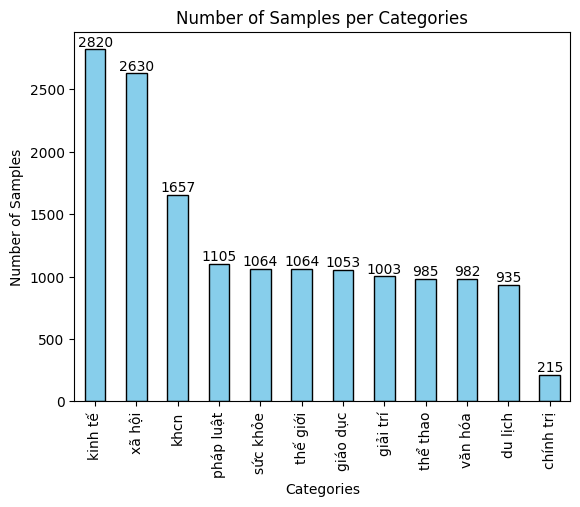

In [11]:
class_counts = raw_data['cat'].value_counts()

ax = class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Samples per Categories')
plt.xlabel('Categories')
plt.ylabel('Number of Samples')

for i, count in enumerate(class_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [12]:
X, y = raw_data['content'].tolist(), raw_data['encoded_cat'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(len(X_train))
print(len(X_test))

9307
6206


In [13]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
print(tokenizer.decode([0, 1, 2, 3, 4, 5, 6, 7, 8, 64000]))

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


<s> <pad> </s> <unk>,. và của là <mask>


In [14]:
!git clone https://github.com/stopwords/vietnamese-stopwords

Cloning into 'vietnamese-stopwords'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 95 (delta 3), reused 0 (delta 0), pack-reused 81 (from 1)
Unpacking objects: 100% (95/95), 40.23 KiB | 1.34 MiB/s, done.


In [15]:
with open('/kaggle/working/vietnamese-stopwords/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    stop_words = file.read()
    stop_words = stop_words.split('\n')
    
print(stop_words[:20])
print(len(stop_words))

['a lô', 'a ha', 'ai', 'ai ai', 'ai nấy', 'ai đó', 'alô', 'amen', 'anh', 'anh ấy', 'ba', 'ba ba', 'ba bản', 'ba cùng', 'ba họ', 'ba ngày', 'ba ngôi', 'ba tăng', 'bao giờ', 'bao lâu']
1942


In [16]:
def remove_stopwords(text, stop_words):
    words = text.split(' ')
    
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    return ' '.join(filtered_words)

class NewsDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

        self.X_cleaned = [remove_stopwords(content, stop_words) for content in tqdm(X)]

    
    def tokenize(self, tokenizer):
        self.tokenized_X = tokenizer(self.X_cleaned,
                                    padding='max_length',
                                    truncation=True,
                                    max_length=8000,
                                    return_tensors="pt"
                                )

    def __getitem__(self, idx):
        return self.tokenized_X['input_ids'][idx], self.tokenized_X['attention_mask'][idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)

100%|██████████| 6206/6206 [01:35<00:00, 64.89it/s]


In [17]:
print(train_dataset.X[0][:100])
print(train_dataset.X_cleaned[0][:100])

Trong đó, đáng kể nhất có lẽ là nhóm nghiên cứu thuộc Học viện Quân y không cần “nghiên cứu” gì mà d
đó, lẽ nghiên cứu Học viện Quân y “nghiên cứu” “phát minh” vợ Phan Quốc Việt lò kit xét nghiệm giá t


In [18]:
print('Tokenizing...')
train_dataset.tokenize(tokenizer)
test_dataset.tokenize(tokenizer)

Tokenizing...


In [19]:
print(train_dataset.tokenized_X['input_ids'].shape)

torch.Size([9307, 8000])


In [20]:
print(train_dataset[0][0].shape)

print(train_dataset.tokenized_X['input_ids'].shape)
print(test_dataset.tokenized_X['input_ids'].shape)

torch.Size([8000])
torch.Size([9307, 8000])
torch.Size([6206, 8000])


In [21]:
torch.save(train_dataset, 'train_dataset.pth')
torch.save(test_dataset, 'test_dataset.pth')

In [22]:
tmp = torch.load('/kaggle/working/train_dataset.pth')
print(tmp[0][0].shape)

/tmp/ipykernel_17/290147885.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tmp = torch.load('/kaggle/working/train_dataset.pth')


torch.Size([8000])
